In [1]:
import warnings

import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f'Shape of df_A: {df_A.shape} and df_B: {df_B.shape}')

Shape of df_A: (27, 10) and df_B: (3, 10)


In [2]:
# import all above models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

regressors = {
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'MLP': MLPRegressor(),
    'XGB': XGBRegressor(),
    'kNN': KNeighborsRegressor(),
    'GB': GradientBoostingRegressor(),
}

# Define hyperparameter grid for each model
param_grid = {
    'LR': {'fit_intercept': [True, False]},
    'RF': {'n_estimators': [3, 5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'SVR': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
    'MLP': {'hidden_layer_sizes': [(25,), (10,)], 'activation': ['identity', 'logistic', 'tanh', 'relu']},
    'XGB': {'n_estimators': [5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'kNN': {'n_neighbors': [1, 2, 3, 5, 10, 20, 50], 'weights': ['uniform', 'distance']},
    'GB': {'n_estimators': [10, 20, 50], 'max_depth': [None, 2, 3, 5, 10]},
}

def model_selection():
    '''
        Define a function to perform the nested Cross Validation
    '''
    def nestedCV(model, p_grid, X, y):
        NUM_TRIALS = 3

        # Arrays to store scores
        nested_scores = []

        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
            outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = GridSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_grid=p_grid, 
                                    cv=inner_cv)
            
            nested_score = cross_val_score(clf, X=X, y=y, 
                                        scoring='neg_mean_absolute_error', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores

    nested_LR, nested_LR_scores = nestedCV(regressors['LR'], param_grid['LR'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_RF, nested_RF_scores = nestedCV(regressors['RF'], param_grid['RF'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_SVR, nested_SVR_scores = nestedCV(regressors['SVR'], param_grid['SVR'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_MLP, nested_MLP_scores = nestedCV(regressors['MLP'], param_grid['MLP'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_XGB, nested_XGB_scores = nestedCV(regressors['XGB'], param_grid['XGB'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_kNN, nested_kNN_scores = nestedCV(regressors['kNN'], param_grid['kNN'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_GB, nested_GB_scores = nestedCV(regressors['GB'], param_grid['GB'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])

    nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
    nested_scores_RF = [-item for sublist in nested_RF_scores for item in sublist]
    nested_scores_SVR = [-item for sublist in nested_SVR_scores for item in sublist]
    nested_scores_MLP = [-item for sublist in nested_MLP_scores for item in sublist]
    nested_scores_XGB = [-item for sublist in nested_XGB_scores for item in sublist]
    nested_scores_kNN = [-item for sublist in nested_kNN_scores for item in sublist]
    nested_scores_GB = [-item for sublist in nested_GB_scores for item in sublist]
        
    # Create a box plot for the nested scores
    def boxplot(save=True):
        plt.figure(figsize=(12, 8))
        positions = [i for i in range(1, len(regressors))]
        plt.boxplot([nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB], labels=['LR', 'RF', 'SVR', 'MLP', 'XGB', 'kNN', 'GB'])
        plt.ylabel('MAE')
        # save figure
        plt.savefig('../figures/boxplot_nestedCV.png')
        plt.show()

        print(f'Mean MAE for LR: {sum(nested_scores_LR)/len(nested_scores_LR)}')
        print(f'Mean MAE for RF: {sum(nested_scores_RF)/len(nested_scores_RF)}')
        print(f'Mean MAE for SVR: {sum(nested_scores_SVR)/len(nested_scores_SVR)}')
        print(f'Mean MAE for MLP: {sum(nested_scores_MLP)/len(nested_scores_MLP)}')
        print(f'Mean MAE for XGB: {sum(nested_scores_XGB)/len(nested_scores_XGB)}')
        print(f'Mean MAE for kNN: {sum(nested_scores_kNN)/len(nested_scores_kNN)}')
        print(f'Mean MAE for GB: {sum(nested_scores_GB)/len(nested_scores_GB)}')

    boxplot()
    
    return nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB


In [3]:
def train_svr(X, y):
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid['SVR'], 
                            scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X, y)
    print("Best Score:", -grid_search.best_score_)
    return grid_search

grid_search = train_svr(df_A[INPUT_VARS], df_A[RESPONSE_VARS].values.ravel())

Best Score: 13.780349939846257


#### Explainable AI 

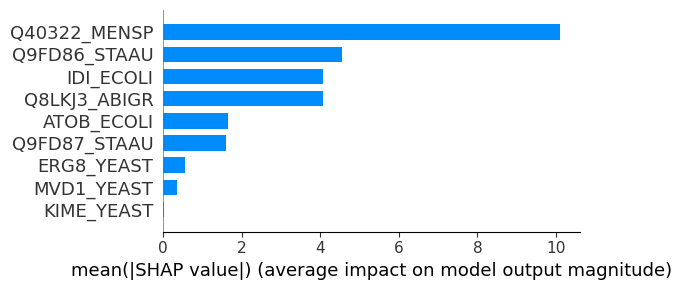

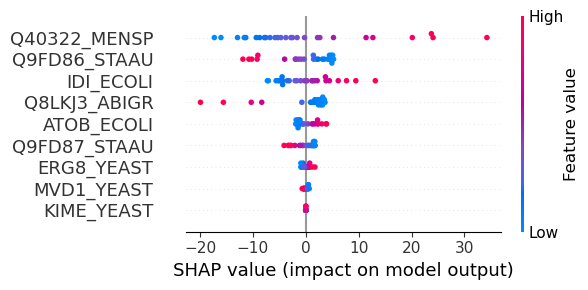

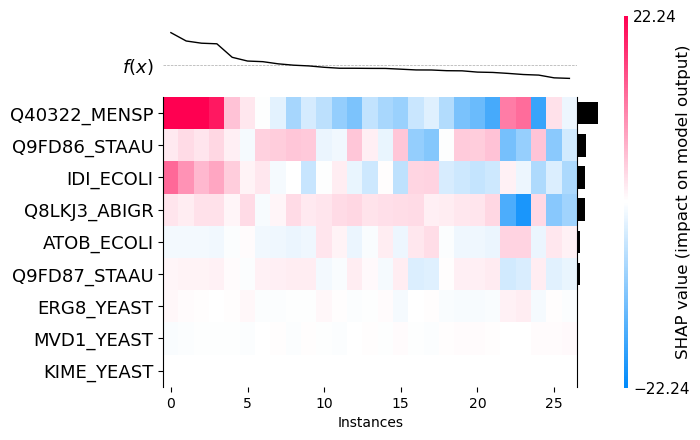

In [4]:
import shap

explainer = shap.Explainer(grid_search.best_estimator_.predict, df_A[INPUT_VARS])
shap_values = explainer(df_A[INPUT_VARS])
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

#### Sampling

In [ ]:
# import all 4 sdv models under the single table scenario
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_A.drop('Limonene', axis=1))

model_Gaussian = GaussianCopulaSynthesizer(metadata)
model_Gaussian.fit(df_A.drop('Limonene', axis=1))
synthetic_data = model_Gaussian.sample(1000)
synthetic_data['Limonene'] = grid_search.best_estimator_.predict(synthetic_data)
synthetic_data.sort_values(by='Limonene', ascending=False, inplace=True)
synthetic_data